In [1]:
import matplotlib.pyplot as plt
import linear_ace.linearfit_nodes 
from importlib import reload

reload(linear_ace.linearfit_nodes)  # Reload the module

# Re-import specific functions or classes if needed
from linear_ace.linearfit_nodes import *  # Re-import everything


# Prelude:

## Loading Dataset:

Firstly, we load the dataset by providing the `file_path`

In [2]:
load_dataset = ReadPickledDatasetAsDataframe(file_path = "linear_ace/Ag10_mp_ase_small.pckl.gz")
load_dataset.pull();

Using the `PlotEnergyHistogram` Node, we can plot the energy histogram

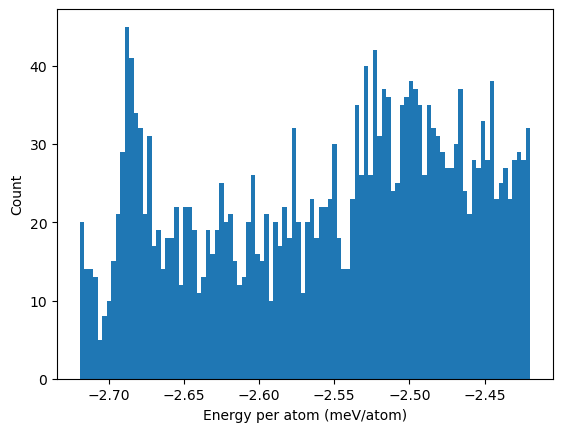

In [3]:
hist_plot = PlotEnergyHistogram(df = load_dataset.outputs.df, log_scale = False)
hist_plot.pull();

Similarly, using the `PlotForcesHistogram` Node, we can plot the forces histogram

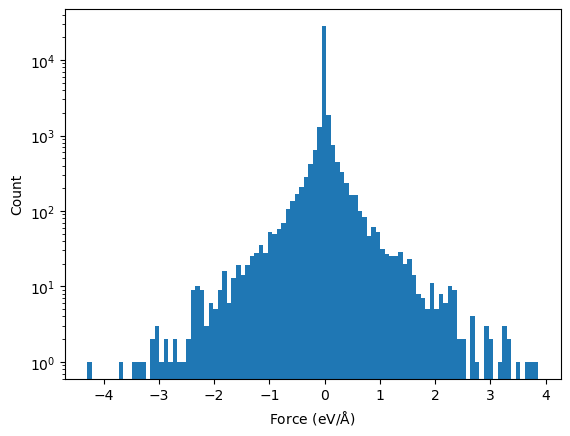

In [4]:
hist_plot = PlotForcesHistogram(df = load_dataset.outputs.df, log_scale = True)
hist_plot.pull();

## Split Dataset into Training and Testing Datasets:

Secondly, we split the dataset into training and testing datasets.

This is done by choosing the percentage used for training dataset through the `training_frac` parameter where `training_frac = 0.5` means we are using 50% for training and 50% for testing.

In [5]:
split_dataset = SplitTrainingAndTesting(data_df = load_dataset.outputs.df, training_frac = 0.5)

## Construct Potential Config:

Similarly in `PACEmaker`, we want to have a similar file to the usual `input.yaml` file that looks like that,

```
fit:
  fit_cycles: 1
  loss: {L1_coeffs: 1e-08, L2_coeffs: 1e-08, kappa: 0.08, w0_rad: 0, w1_rad: 0, w2_rad: 0}
  maxiter: 1000
  optimizer: BFGS
  trainable_parameters: ALL
  weighting: {DE: 1.0, DElow: 1.0, DEup: 10.0, DF: 1.0, DFup: 50.0, energy: convex_hull,
    nfit: 20000, reftype: all, seed: 42, type: EnergyBasedWeightingPolicy, wlow: 0.95}
.
.
.
potential:
  bonds:
    ALL:
      dcut: 0.01
      radbase: SBessel
      radparameters: [5.25]
      rcut: 6.0
  elements: [Mg, Ca]
  embeddings:
    ALL:
      fs_parameters: [1, 1, 1, 0.5]
      ndensity: 2
      npot: FinnisSinclairShiftedScaled
  functions:
    number_of_functions_per_element = 300
    ALL:
      lmax_by_orders: [15, 6, 2, 1]
      nradmax_by_orders: [0, 6, 3, 1]
      ```

For simplicity, the main inputs that we will consider for the potential configurations are,

- `number_of_functions_per_element`: specifies how many functions will be provided in the potential
- `rcut`: specifies what the cutoff radius is

In [6]:
parameterize_potential = ParameterizePotentialConfig(number_of_functions_per_element = 10, rcut = 6.0)

Check the current potential configurations in dictionary format,

In [7]:
parameterize_potential.pull().to_dict()

{'deltaSplineBins': 0.001,
 'embeddings': {'ALL': {'npot': 'FinnisSinclairShiftedScaled',
   'fs_parameters': [1, 1],
   'ndensity': 1}},
 'bonds': {'ALL': {'radbase': 'SBessel',
   'radparameters': [5.25],
   'rcut': 6.0,
   'dcut': 0.01}},
 'functions': {'number_of_functions_per_element': 10,
  'ALL': {'nradmax_by_orders': [15, 6, 4, 1], 'lmax_by_orders': [0, 6, 5, 1]}}}

## Linear Fitting:

We can then create the design matrix for both training and testing datasets using the basis set (`bconf`).

**Note:** Setting `verbose = True` will show all the details of building the design matrices.

In [8]:
create_descriptors = PrepareLinearACEdataset(potential_config = parameterize_potential,
                                                df_train = split_dataset.outputs.df_training,
                                                df_test= split_dataset.outputs.df_testing, verbose = False)

We can then then run our fit and save the potential files inside a new folder.

In [9]:
run_linear_fit = RunLinearFit(train_ds = create_descriptors.outputs.train_ds, test_ds = create_descriptors.outputs.test_ds)

In [10]:
save_potential = SavePotential(basis = run_linear_fit.outputs.basis)

In [11]:
save_potential.pull()

====================== TRAINING INFO ======================
Training E RMSE: 22.47 meV/atom
Training F RMSE: 37.12 meV/A
======================= TESTING INFO =======================
Testing E RMSE: 22.59 meV/atom
Testing F RMSE: 40.87 meV/A
Potentials "Ag_linear_potential.yaml" and "Ag_linear_potential.yace" are saved in "/cmmc/u/hgaafer/pyiron/projects/2025_03_16_DPG_workshop/linear-ace_nodes/Linear_ace_potentials".


(<pyace.basis.ACEBBasisSet at 0x14f360288770>,
 '/cmmc/u/hgaafer/pyiron/projects/2025_03_16_DPG_workshop/linear-ace_nodes/Linear_ace_potentials/Ag_linear_potential.yace')

# Workflow:

In [12]:
wf = Workflow('Linear Ace Model', delete_existing_savefiles=False)

In [13]:
wf.load_dataset = ReadPickledDatasetAsDataframe(file_path = "linear_ace/Ag10_mp_ase_small.pckl.gz")
wf.split_dataset = SplitTrainingAndTesting(data_df = wf.load_dataset.outputs.df, training_frac = 0.5)
wf.parameterize_potential = ParameterizePotentialConfig(number_of_functions_per_element = 10, rcut = 6.0)
wf.create_descriptors = PrepareLinearACEdataset(potential_config = wf.parameterize_potential,
                                                df_train = wf.split_dataset.outputs.df_training,
                                                df_test=wf.split_dataset.outputs.df_testing, verbose = False)
wf.run_linear_fit = RunLinearFit(train_ds = wf.create_descriptors.outputs.train_ds, test_ds = wf.create_descriptors.outputs.test_ds)
wf.save_potential = SavePotential(basis = wf.run_linear_fit.outputs.basis)
wf.predict_energies_forces = PredictEnergiesAndForces(wf.save_potential.outputs.basis,train_ds = wf.create_descriptors.outputs.train_ds, test_ds = wf.create_descriptors.outputs.test_ds)

2025-03-06 21:35:53,160 - pyiron_log - INFO - Assigning a channel with the label file_path to the io key load_dataset__file_path
2025-03-06 21:35:53,162 - pyiron_log - INFO - Assigning a channel with the label compression to the io key load_dataset__compression
2025-03-06 21:35:53,163 - pyiron_log - INFO - Assigning a channel with the label training_frac to the io key split_dataset__training_frac
2025-03-06 21:35:53,164 - pyiron_log - INFO - Assigning a channel with the label random_state to the io key split_dataset__random_state
2025-03-06 21:35:53,165 - pyiron_log - INFO - Assigning a channel with the label nrad_max to the io key parameterize_potential__nrad_max
2025-03-06 21:35:53,167 - pyiron_log - INFO - Assigning a channel with the label l_max to the io key parameterize_potential__l_max
2025-03-06 21:35:53,167 - pyiron_log - INFO - Assigning a channel with the label number_of_functions_per_element to the io key parameterize_potential__number_of_functions_per_element
2025-03-06 21

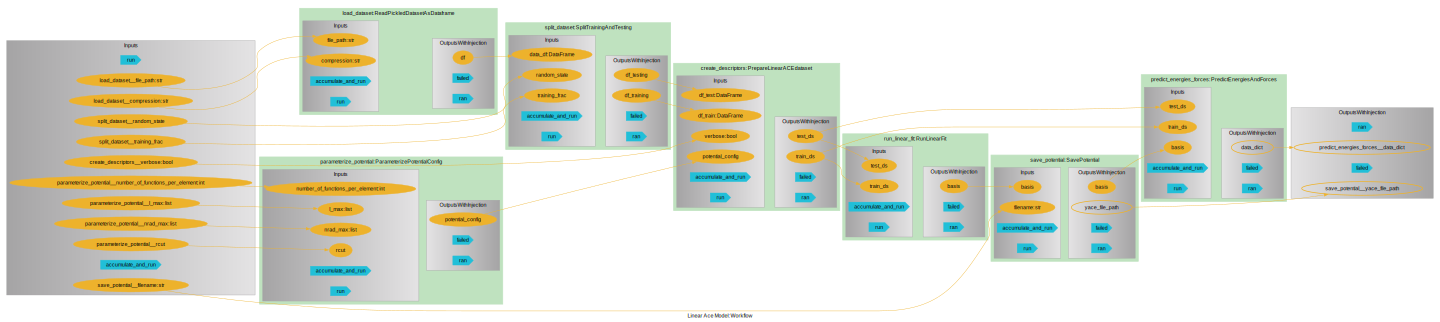

In [14]:
wf.draw(size=(20,10))

In [15]:
output = wf.run()

2025-03-06 21:35:53,284 - pyiron_log - INFO - Assigning a channel with the label file_path to the io key load_dataset__file_path
2025-03-06 21:35:53,286 - pyiron_log - INFO - Assigning a channel with the label compression to the io key load_dataset__compression
2025-03-06 21:35:53,287 - pyiron_log - INFO - Assigning a channel with the label training_frac to the io key split_dataset__training_frac
2025-03-06 21:35:53,288 - pyiron_log - INFO - Assigning a channel with the label random_state to the io key split_dataset__random_state
2025-03-06 21:35:53,290 - pyiron_log - INFO - Assigning a channel with the label nrad_max to the io key parameterize_potential__nrad_max
2025-03-06 21:35:53,290 - pyiron_log - INFO - Assigning a channel with the label l_max to the io key parameterize_potential__l_max
2025-03-06 21:35:53,291 - pyiron_log - INFO - Assigning a channel with the label number_of_functions_per_element to the io key parameterize_potential__number_of_functions_per_element
2025-03-06 21

====================== TRAINING INFO ======================
Training E RMSE: 22.47 meV/atom
Training F RMSE: 37.12 meV/A
======================= TESTING INFO =======================
Testing E RMSE: 22.59 meV/atom
Testing F RMSE: 40.87 meV/A
Potentials "Ag_linear_potential.yaml" and "Ag_linear_potential.yace" are saved in "/cmmc/u/hgaafer/pyiron/projects/2025_03_16_DPG_workshop/linear-ace_nodes/Linear_ace_potentials".


2025-03-06 21:35:55,768 - pyiron_log - INFO - Assigning a channel with the label yace_file_path to the io key save_potential__yace_file_path
2025-03-06 21:35:55,769 - pyiron_log - INFO - Assigning a channel with the label data_dict to the io key predict_energies_forces__data_dict


In [16]:
data_dict = output['predict_energies_forces__data_dict']

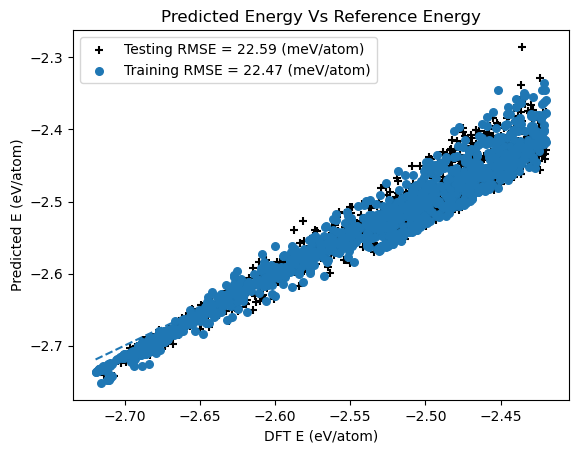

In [17]:
fitting_plot = PlotEnergyFittingCurve(data_dict)
fitting_plot.pull();

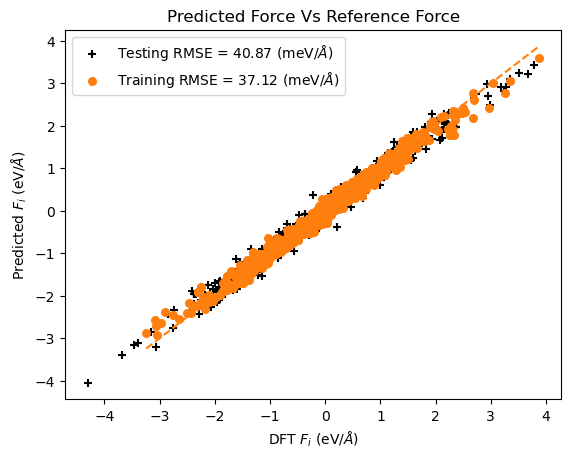

In [18]:
fitting_plot = PlotForcesFittingCurve(data_dict)
fitting_plot.pull();

In [19]:
wf.inputs.parameterize_potential__number_of_functions_per_element = 30

2025-03-06 21:35:56,478 - pyiron_log - INFO - Assigning a channel with the label file_path to the io key load_dataset__file_path
2025-03-06 21:35:56,480 - pyiron_log - INFO - Assigning a channel with the label compression to the io key load_dataset__compression
2025-03-06 21:35:56,482 - pyiron_log - INFO - Assigning a channel with the label training_frac to the io key split_dataset__training_frac
2025-03-06 21:35:56,483 - pyiron_log - INFO - Assigning a channel with the label random_state to the io key split_dataset__random_state
2025-03-06 21:35:56,484 - pyiron_log - INFO - Assigning a channel with the label nrad_max to the io key parameterize_potential__nrad_max
2025-03-06 21:35:56,486 - pyiron_log - INFO - Assigning a channel with the label l_max to the io key parameterize_potential__l_max
2025-03-06 21:35:56,486 - pyiron_log - INFO - Assigning a channel with the label number_of_functions_per_element to the io key parameterize_potential__number_of_functions_per_element
2025-03-06 21

In [20]:
output = wf.run()

2025-03-06 21:35:56,496 - pyiron_log - INFO - Assigning a channel with the label file_path to the io key load_dataset__file_path
2025-03-06 21:35:56,497 - pyiron_log - INFO - Assigning a channel with the label compression to the io key load_dataset__compression
2025-03-06 21:35:56,498 - pyiron_log - INFO - Assigning a channel with the label training_frac to the io key split_dataset__training_frac
2025-03-06 21:35:56,499 - pyiron_log - INFO - Assigning a channel with the label random_state to the io key split_dataset__random_state
2025-03-06 21:35:56,499 - pyiron_log - INFO - Assigning a channel with the label nrad_max to the io key parameterize_potential__nrad_max
2025-03-06 21:35:56,500 - pyiron_log - INFO - Assigning a channel with the label l_max to the io key parameterize_potential__l_max
2025-03-06 21:35:56,500 - pyiron_log - INFO - Assigning a channel with the label number_of_functions_per_element to the io key parameterize_potential__number_of_functions_per_element
2025-03-06 21

====================== TRAINING INFO ======================
Training E RMSE: 5.66 meV/atom
Training F RMSE: 8.25 meV/A
======================= TESTING INFO =======================
Testing E RMSE: 5.94 meV/atom
Testing F RMSE: 9.06 meV/A
Potentials "Ag_linear_potential.yaml" and "Ag_linear_potential.yace" are saved in "/cmmc/u/hgaafer/pyiron/projects/2025_03_16_DPG_workshop/linear-ace_nodes/Linear_ace_potentials".


2025-03-06 21:35:59,658 - pyiron_log - INFO - Assigning a channel with the label yace_file_path to the io key save_potential__yace_file_path
2025-03-06 21:35:59,662 - pyiron_log - INFO - Assigning a channel with the label data_dict to the io key predict_energies_forces__data_dict


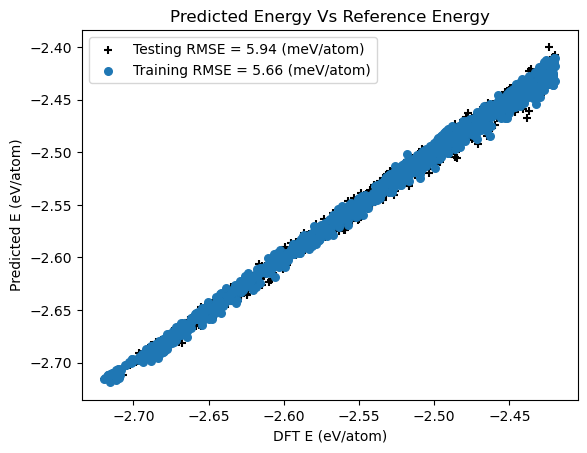

In [21]:
fitting_plot = PlotEnergyFittingCurve(output['predict_energies_forces__data_dict'])
fitting_plot.pull();

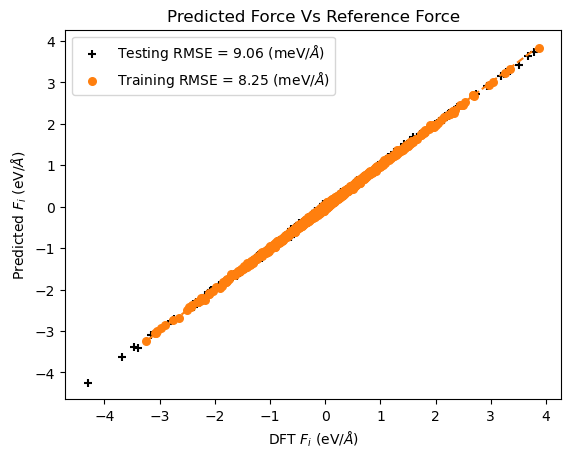

In [22]:
fitting_plot = PlotForcesFittingCurve(output['predict_energies_forces__data_dict'])
fitting_plot.pull();

In [23]:
from pyironflow.pyironflow import PyironFlow

In [24]:
pf = PyironFlow([wf], root_path='linear_ace')
pf.gui